<a href="https://colab.research.google.com/github/Jitheshkumar08/Deep-Learning-From-Scratch-MLP-Autoencoder-RBM-NumPy/blob/main/DL_TASK1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf

# 2. Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 3. Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 4. Flatten the image data
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# 5. Rename x_test and y_test to x_val and y_val
x_val = x_test
y_val = y_test

print("Dataset loaded, normalized, flattened, and split into training and validation sets.")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

Dataset loaded, normalized, flattened, and split into training and validation sets.
x_train shape: (60000, 784)
y_train shape: (60000,)
x_val shape: (10000, 784)
y_val shape: (10000,)


In [14]:
import numpy as np

# 1. Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 2. Derivative of Sigmoid
def sigmoid_derivative(a):
    return a * (1 - a)

# 3. ReLU activation function
def relu(z):
    return np.maximum(0, z)

# 4. Derivative of ReLU
def relu_derivative(z):
    return (z > 0).astype(float)

# 5. Tanh activation function
def tanh(z):
    return np.tanh(z)

# 6. Derivative of Tanh
def tanh_derivative(a):
    return 1 - np.power(a, 2)

# 7. Softmax activation function
def softmax(z):
    # Subtract max for numerical stability to prevent overflow
    exp_z = np.exp(z - np.max(z, axis=-1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=-1, keepdims=True)

# 8. Cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-10  # Small epsilon to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon) # Clip probabilities to avoid log(0) or log(1)
    # One-hot encode y_true if it's not already
    if y_true.ndim == 1:
        num_classes = y_pred.shape[1]
        y_true_one_hot = np.eye(num_classes)[y_true]
    else:
        y_true_one_hot = y_true

    loss = -np.sum(y_true_one_hot * np.log(y_pred)) / y_true.shape[0]
    return loss

print("Core neural network functions (Sigmoid, ReLU, Tanh, Softmax, Cross-Entropy Loss) and their derivatives defined.")

Core neural network functions (Sigmoid, ReLU, Tanh, Softmax, Cross-Entropy Loss) and their derivatives defined.


In [15]:
class TwoLayerMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        # Weights are initialized with small random numbers
        # Biases are initialized to zeros
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.B1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.B2 = np.zeros((1, self.output_size))

    def forward(self, X):
        # Layer 1 (Hidden Layer)
        self.Z1 = X @ self.W1 + self.B1
        self.A1 = relu(self.Z1) # Apply ReLU activation

        # Layer 2 (Output Layer)
        self.Z2 = self.A1 @ self.W2 + self.B2
        self.A2 = softmax(self.Z2) # Apply Softmax activation

        return self.A2

    def backward(self, X, y_true):
        m = X.shape[0] # Number of samples

        # Convert y_true to one-hot encoding if it's not already
        # Assuming y_true is a 1D array of class labels
        if y_true.ndim == 1:
            y_true_one_hot = np.eye(self.output_size)[y_true]
        else:
            y_true_one_hot = y_true

        # Output layer gradients
        dZ2 = self.A2 - y_true_one_hot
        dW2 = (self.A1.T @ dZ2) / m
        dB2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Hidden layer gradients
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = (X.T @ dZ1) / m
        dB1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return dW1, dB1, dW2, dB2

    def update_parameters(self, dW1, dB1, dW2, dB2):
        self.W1 -= self.learning_rate * dW1
        self.B1 -= self.learning_rate * dB1
        self.W2 -= self.learning_rate * dW2
        self.B2 -= self.learning_rate * dB2

print("TwoLayerMLP class defined with forward, backward, and update_parameters methods.")


TwoLayerMLP class defined with forward, backward, and update_parameters methods.


In [16]:
def calculate_accuracy(y_true, y_pred_probs):
    y_pred = np.argmax(y_pred_probs, axis=1)
    return np.mean(y_true == y_pred) * 100

print("Accuracy calculation function defined.")

Accuracy calculation function defined.


In [17]:
input_size = x_train.shape[1]
output_size = len(np.unique(y_train)) # Number of classes in y_train

# Hyperparameters to tune
learning_rates = [0.01, 0.001]
hidden_layer_sizes = [128, 256]
batch_sizes = [64, 128]
epochs = 10

best_accuracy = -1
best_params = {}
best_mlp_model = None

print("Starting hyperparameter tuning...")

# Loop through hyperparameter combinations
for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        for batch_size in batch_sizes:
            print(f"\nTraining with LR: {lr}, Hidden Size: {hidden_size}, Batch Size: {batch_size}")

            # Initialize MLP model
            mlp = TwoLayerMLP(input_size, hidden_size, output_size, lr)

            # Store history for current configuration
            history = {
                'train_loss': [], 'train_accuracy': [],
                'val_loss': [], 'val_accuracy': []
            }

            # Training loop
            for epoch in range(epochs):
                # Shuffle training data at the beginning of each epoch
                permutation = np.random.permutation(x_train.shape[0])
                shuffled_x_train = x_train[permutation]
                shuffled_y_train = y_train[permutation]

                # Mini-batch training
                num_batches = int(np.ceil(x_train.shape[0] / batch_size))
                total_train_loss = 0

                for i in range(num_batches):
                    start = i * batch_size
                    end = min((i + 1) * batch_size, x_train.shape[0])

                    batch_x = shuffled_x_train[start:end]
                    batch_y = shuffled_y_train[start:end]

                    # Forward pass
                    y_pred_batch = mlp.forward(batch_x)

                    # Calculate loss
                    loss_batch = cross_entropy_loss(batch_y, y_pred_batch)
                    total_train_loss += loss_batch

                    # Backward pass and parameter update
                    dW1, dB1, dW2, dB2 = mlp.backward(batch_x, batch_y)
                    mlp.update_parameters(dW1, dB1, dW2, dB2)

                avg_train_loss = total_train_loss / num_batches

                # Evaluate performance on training set
                y_pred_train_probs = mlp.forward(x_train)
                train_accuracy = calculate_accuracy(y_train, y_pred_train_probs)

                # Evaluate performance on validation set
                y_pred_val_probs = mlp.forward(x_val)
                val_loss = cross_entropy_loss(y_val, y_pred_val_probs)
                val_accuracy = calculate_accuracy(y_val, y_pred_val_probs)

                history['train_loss'].append(avg_train_loss)
                history['train_accuracy'].append(train_accuracy)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_accuracy)

                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

            # After all epochs for this configuration, check if it's the best
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'learning_rate': lr, 'hidden_size': hidden_size, 'batch_size': batch_size}
                best_mlp_model = mlp # Store the best performing model

print("\nHyperparameter tuning completed.")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
print(f"Best Hyperparameters: {best_params}")

Starting hyperparameter tuning...

Training with LR: 0.01, Hidden Size: 128, Batch Size: 64
Epoch 1/10 - Train Loss: 1.5135, Train Acc: 64.71%, Val Loss: 0.9432, Val Acc: 64.27%
Epoch 2/10 - Train Loss: 0.8006, Train Acc: 73.56%, Val Loss: 0.7323, Val Acc: 72.32%
Epoch 3/10 - Train Loss: 0.6651, Train Acc: 78.48%, Val Loss: 0.6403, Val Acc: 77.68%
Epoch 4/10 - Train Loss: 0.5906, Train Acc: 80.38%, Val Loss: 0.5890, Val Acc: 79.30%
Epoch 5/10 - Train Loss: 0.5448, Train Acc: 82.01%, Val Loss: 0.5558, Val Acc: 80.64%
Epoch 6/10 - Train Loss: 0.5151, Train Acc: 82.77%, Val Loss: 0.5281, Val Acc: 81.48%
Epoch 7/10 - Train Loss: 0.4945, Train Acc: 83.31%, Val Loss: 0.5149, Val Acc: 81.96%
Epoch 8/10 - Train Loss: 0.4794, Train Acc: 83.67%, Val Loss: 0.5046, Val Acc: 82.13%
Epoch 9/10 - Train Loss: 0.4679, Train Acc: 82.87%, Val Loss: 0.5192, Val Acc: 81.42%
Epoch 10/10 - Train Loss: 0.4579, Train Acc: 83.65%, Val Loss: 0.4987, Val Acc: 82.06%

Training with LR: 0.01, Hidden Size: 128, Batc

Re-training best model with LR: 0.01, Hidden Size: 256, Batch Size: 64
Epoch 1/10 - Train Loss: 1.4302, Train Acc: 67.87%, Val Loss: 0.8945, Val Acc: 66.50%
Epoch 2/10 - Train Loss: 0.7684, Train Acc: 75.75%, Val Loss: 0.7070, Val Acc: 74.60%
Epoch 3/10 - Train Loss: 0.6415, Train Acc: 78.97%, Val Loss: 0.6253, Val Acc: 77.95%
Epoch 4/10 - Train Loss: 0.5735, Train Acc: 81.58%, Val Loss: 0.5725, Val Acc: 80.23%
Epoch 5/10 - Train Loss: 0.5315, Train Acc: 82.59%, Val Loss: 0.5427, Val Acc: 81.14%
Epoch 6/10 - Train Loss: 0.5063, Train Acc: 82.95%, Val Loss: 0.5227, Val Acc: 81.59%
Epoch 7/10 - Train Loss: 0.4866, Train Acc: 83.69%, Val Loss: 0.5053, Val Acc: 82.25%
Epoch 8/10 - Train Loss: 0.4727, Train Acc: 83.74%, Val Loss: 0.5008, Val Acc: 82.37%
Epoch 9/10 - Train Loss: 0.4607, Train Acc: 84.21%, Val Loss: 0.4877, Val Acc: 82.79%
Epoch 10/10 - Train Loss: 0.4513, Train Acc: 84.26%, Val Loss: 0.4861, Val Acc: 82.86%
Best model re-trained and history captured.


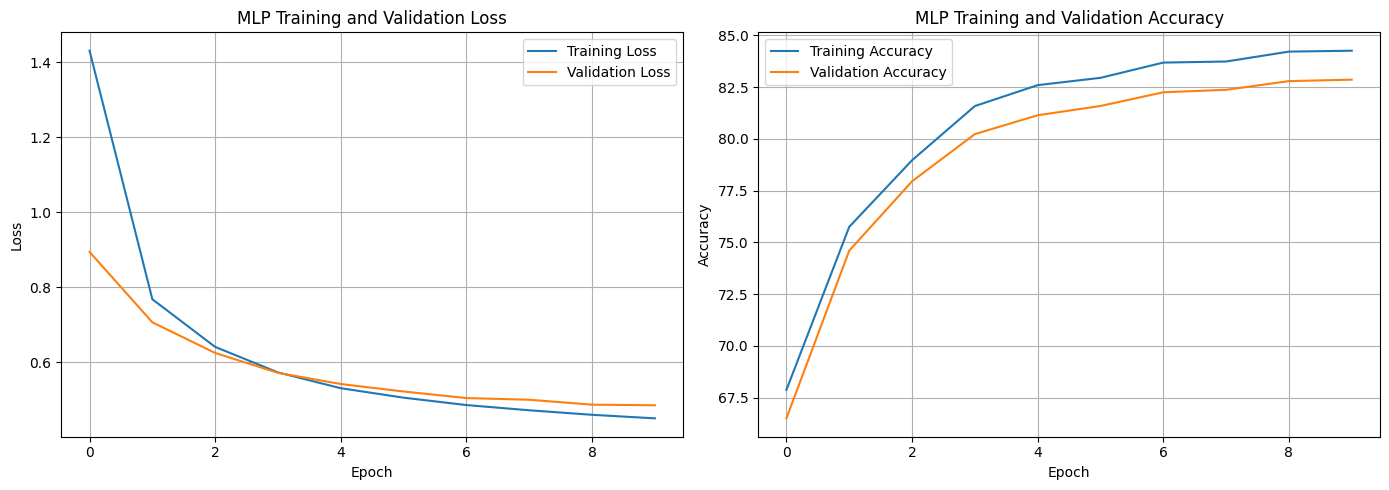

In [18]:
import matplotlib.pyplot as plt

# Retrieve best hyperparameters
best_lr = best_params['learning_rate']
best_hidden_size = best_params['hidden_size']
best_batch_size = best_params['batch_size']

print(f"Re-training best model with LR: {best_lr}, Hidden Size: {best_hidden_size}, Batch Size: {best_batch_size}")

# Initialize MLP model with best hyperparameters
final_mlp = TwoLayerMLP(input_size, best_hidden_size, output_size, best_lr)

# Store history for the final best configuration
final_history = {
    'train_loss': [], 'train_accuracy': [],
    'val_loss': [], 'val_accuracy': []
}

# Training loop for the best model
for epoch in range(epochs):
    # Shuffle training data at the beginning of each epoch
    permutation = np.random.permutation(x_train.shape[0])
    shuffled_x_train = x_train[permutation]
    shuffled_y_train = y_train[permutation]

    # Mini-batch training
    num_batches = int(np.ceil(x_train.shape[0] / best_batch_size))
    total_train_loss = 0

    for i in range(num_batches):
        start = i * best_batch_size
        end = min((i + 1) * best_batch_size, x_train.shape[0])

        batch_x = shuffled_x_train[start:end]
        batch_y = shuffled_y_train[start:end]

        # Forward pass
        y_pred_batch = final_mlp.forward(batch_x)

        # Calculate loss
        loss_batch = cross_entropy_loss(batch_y, y_pred_batch)
        total_train_loss += loss_batch

        # Backward pass and parameter update
        dW1, dB1, dW2, dB2 = final_mlp.backward(batch_x, batch_y)
        final_mlp.update_parameters(dW1, dB1, dW2, dB2)

    avg_train_loss = total_train_loss / num_batches

    # Evaluate performance on training set
    y_pred_train_probs = final_mlp.forward(x_train)
    train_accuracy = calculate_accuracy(y_train, y_pred_train_probs)

    # Evaluate performance on validation set
    y_pred_val_probs = final_mlp.forward(x_val)
    val_loss = cross_entropy_loss(y_val, y_pred_val_probs)
    val_accuracy = calculate_accuracy(y_val, y_pred_val_probs)

    final_history['train_loss'].append(avg_train_loss)
    final_history['train_accuracy'].append(train_accuracy)
    final_history['val_loss'].append(val_loss)
    final_history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Best model re-trained and history captured.")

# Plotting the training and validation curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(final_history['train_loss'], label='Training Loss')
axes[0].plot(final_history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MLP Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(final_history['train_accuracy'], label='Training Accuracy')
axes[1].plot(final_history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('MLP Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [19]:
class Autoencoder:
    def __init__(self, input_size, hidden_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Encoder weights and biases
        self.W_enc = np.random.randn(input_size, hidden_size) * 0.01
        self.B_enc = np.zeros((1, hidden_size))

        # Decoder weights and biases
        self.W_dec = np.random.randn(hidden_size, input_size) * 0.01
        self.B_dec = np.zeros((1, input_size))

    def encoder_forward(self, X):
        # Linear transformation
        self.Z_enc = X @ self.W_enc + self.B_enc
        # Activation function (ReLU for encoder latent space)
        self.H = relu(self.Z_enc) # Latent representation
        return self.H

    def decoder_forward(self, H):
        # Linear transformation
        self.Z_dec = H @ self.W_dec + self.B_dec
        # Activation function (Sigmoid for reconstruction, as pixel values are normalized [0, 1])
        self.X_reconstructed = sigmoid(self.Z_dec)
        return self.X_reconstructed

    def forward(self, X):
        # Store input for backward pass
        self.X = X
        # Encode
        H = self.encoder_forward(X)
        # Decode
        X_reconstructed = self.decoder_forward(H)
        return X_reconstructed

    def backward(self, X_reconstructed, X_true):
        m = X_true.shape[0] # Number of samples

        # Calculate reconstruction error (Mean Squared Error derivative)
        # dLoss/dX_reconstructed
        dLoss_dX_reconstructed = (X_reconstructed - X_true) * 2 / m

        # Backpropagate through decoder
        # dLoss/dZ_dec = dLoss/dX_reconstructed * dX_reconstructed/dZ_dec
        dZ_dec = dLoss_dX_reconstructed * sigmoid_derivative(X_reconstructed) # Using X_reconstructed (A_dec) as 'a'
        dW_dec = (self.H.T @ dZ_dec) # dLoss/dW_dec
        dB_dec = np.sum(dZ_dec, axis=0, keepdims=True) # dLoss/dB_dec

        # Backpropagate through encoder
        # dLoss/dH = dLoss/dZ_dec * dZ_dec/dH = dZ_dec @ W_dec.T
        dH = dZ_dec @ self.W_dec.T
        # dLoss/dZ_enc = dLoss/dH * dH/dZ_enc
        dZ_enc = dH * relu_derivative(self.Z_enc)
        dW_enc = (self.X.T @ dZ_enc) # dLoss/dW_enc
        dB_enc = np.sum(dZ_enc, axis=0, keepdims=True) # dLoss/dB_enc

        return dW_enc, dB_enc, dW_dec, dB_dec

    def update_parameters(self, dW_enc, dB_enc, dW_dec, dB_dec):
        self.W_enc -= self.learning_rate * dW_enc
        self.B_enc -= self.learning_rate * dB_enc
        self.W_dec -= self.learning_rate * dW_dec
        self.B_dec -= self.learning_rate * dB_dec

# Define Mean Squared Error for Autoencoder
def mse_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

print("Autoencoder class defined with encoder, decoder, forward, backward, and update methods, along with MSE loss function.")

Autoencoder class defined with encoder, decoder, forward, backward, and update methods, along with MSE loss function.


Initializing Autoencoder with Input Size: 784, Hidden Size: 128, Learning Rate: 0.001
Starting Autoencoder training...
Epoch 1/20 - Avg Training Loss: 0.107789
Epoch 2/20 - Avg Training Loss: 0.075011
Epoch 3/20 - Avg Training Loss: 0.060593
Epoch 4/20 - Avg Training Loss: 0.054794
Epoch 5/20 - Avg Training Loss: 0.050753
Epoch 6/20 - Avg Training Loss: 0.046902
Epoch 7/20 - Avg Training Loss: 0.043624
Epoch 8/20 - Avg Training Loss: 0.040885
Epoch 9/20 - Avg Training Loss: 0.038463
Epoch 10/20 - Avg Training Loss: 0.036189
Epoch 11/20 - Avg Training Loss: 0.034088
Epoch 12/20 - Avg Training Loss: 0.032260
Epoch 13/20 - Avg Training Loss: 0.030721
Epoch 14/20 - Avg Training Loss: 0.029420
Epoch 15/20 - Avg Training Loss: 0.028321
Epoch 16/20 - Avg Training Loss: 0.027390
Epoch 17/20 - Avg Training Loss: 0.026586
Epoch 18/20 - Avg Training Loss: 0.025889
Epoch 19/20 - Avg Training Loss: 0.025285
Epoch 20/20 - Avg Training Loss: 0.024747
Autoencoder training completed.


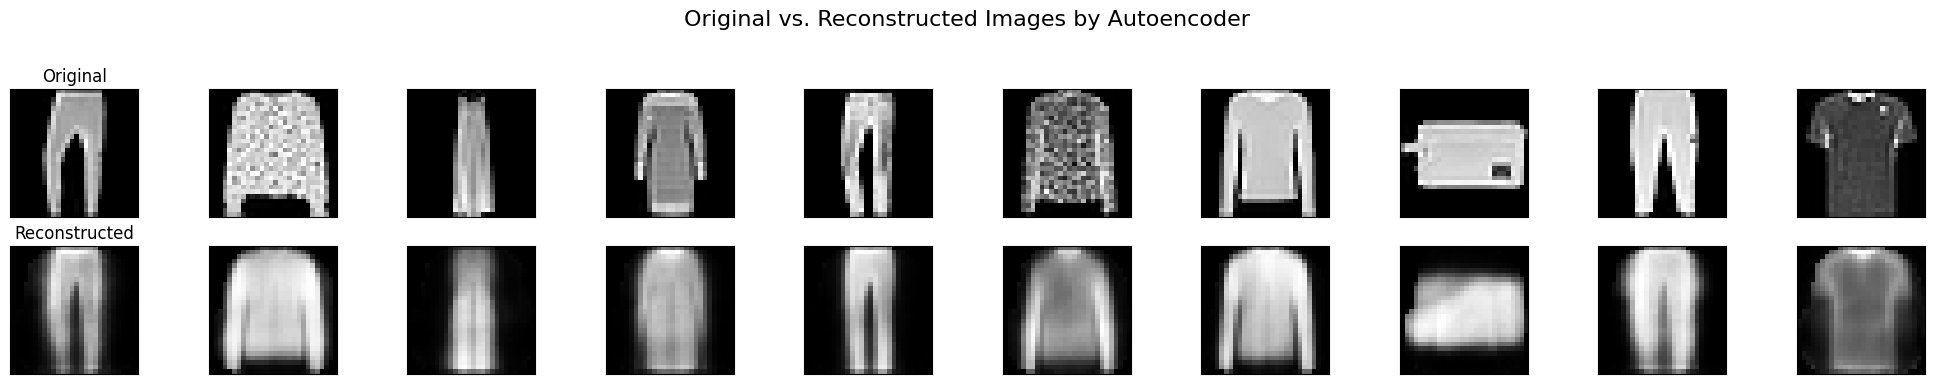

In [20]:
input_size_ae = x_train.shape[1] # 784
hidden_size_ae = 128 # Bottleneck layer size
learning_rate_ae = 0.001
epochs_ae = 20
batch_size_ae = 128

print(f"Initializing Autoencoder with Input Size: {input_size_ae}, Hidden Size: {hidden_size_ae}, Learning Rate: {learning_rate_ae}")
autoencoder = Autoencoder(input_size_ae, hidden_size_ae, learning_rate_ae)

print("Starting Autoencoder training...")

# Training loop for Autoencoder
for epoch in range(epochs_ae):
    # Shuffle training data at the beginning of each epoch
    permutation_ae = np.random.permutation(x_train.shape[0])
    shuffled_x_train_ae = x_train[permutation_ae]

    num_batches_ae = int(np.ceil(x_train.shape[0] / batch_size_ae))
    total_train_loss_ae = 0

    for i in range(num_batches_ae):
        start_ae = i * batch_size_ae
        end_ae = min((i + 1) * batch_size_ae, x_train.shape[0])

        batch_x_ae = shuffled_x_train_ae[start_ae:end_ae]

        # Forward pass
        x_reconstructed_batch_ae = autoencoder.forward(batch_x_ae)

        # Calculate loss
        loss_batch_ae = mse_loss(batch_x_ae, x_reconstructed_batch_ae)
        total_train_loss_ae += loss_batch_ae

        # Backward pass and parameter update
        dW_enc_ae, dB_enc_ae, dW_dec_ae, dB_dec_ae = autoencoder.backward(x_reconstructed_batch_ae, batch_x_ae)
        autoencoder.update_parameters(dW_enc_ae, dB_enc_ae, dW_dec_ae, dB_dec_ae)

    avg_train_loss_ae = total_train_loss_ae / num_batches_ae
    print(f"Epoch {epoch+1}/{epochs_ae} - Avg Training Loss: {avg_train_loss_ae:.6f}")

print("Autoencoder training completed.")

# 4. Select a small number of images from the validation set
num_images_to_show = 10
indices = np.random.choice(x_val.shape[0], num_images_to_show, replace=False)
sample_images = x_val[indices]

# 5. Pass these selected images through the trained autoencoder to get reconstructions
reconstructed_images = autoencoder.forward(sample_images)

# 6. Visualize original and reconstructed images side-by-side
plt.figure(figsize=(20, 4))
for i in range(num_images_to_show):
    # Original Image
    ax = plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: # Add title only to the first image of the row
        ax.set_title('Original')

    # Reconstructed Image
    ax = plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: # Add title only to the first image of the row
        ax.set_title('Reconstructed')

plt.suptitle('Original vs. Reconstructed Images by Autoencoder', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Starting Outlier Detection using Autoencoder...
Calculated reconstruction errors for 10000 validation images.
Mean Reconstruction Error: 0.024530
Standard Deviation of Reconstruction Error: 0.012327
Outlier Threshold (Mean + 3*StdDev): 0.061510
Number of outliers detected: 177
Number of normal images: 9823
Displaying selected examples...


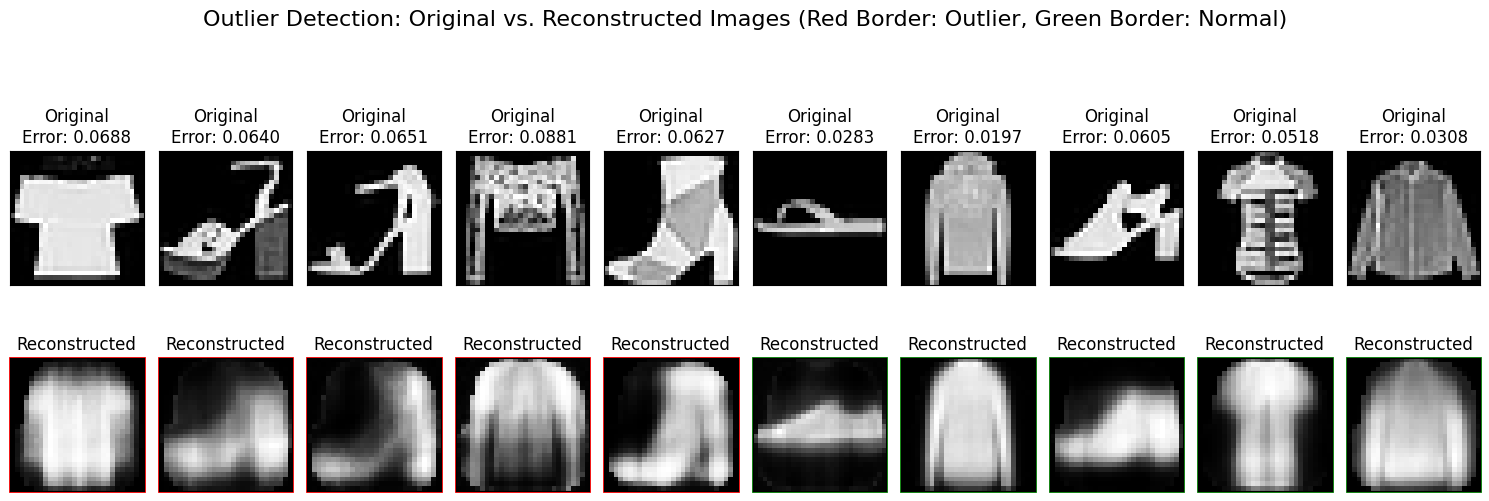

Outlier detection demonstration complete.


In [21]:
print("Starting Outlier Detection using Autoencoder...")

# 1. Calculate reconstruction error (MSE) for all images in x_val
x_val_reconstructed = autoencoder.forward(x_val)
reconstruction_errors = np.array([mse_loss(x_val[i].reshape(1, -1), x_val_reconstructed[i].reshape(1, -1)) for i in range(x_val.shape[0])])

print(f"Calculated reconstruction errors for {len(reconstruction_errors)} validation images.")

# 2. Determine a suitable threshold for outlier detection
mean_error = np.mean(reconstruction_errors)
std_dev_error = np.std(reconstruction_errors)

# Using mean + 3 * std_dev as the threshold
threshold = mean_error + 3 * std_dev_error
# Alternatively, using a percentile-based approach (e.g., 99th percentile)
# threshold = np.percentile(reconstruction_errors, 99)

print(f"Mean Reconstruction Error: {mean_error:.6f}")
print(f"Standard Deviation of Reconstruction Error: {std_dev_error:.6f}")
print(f"Outlier Threshold (Mean + 3*StdDev): {threshold:.6f}")

# 3. Identify which images in x_val are classified as outliers
outlier_indices = np.where(reconstruction_errors > threshold)[0]
normal_indices = np.where(reconstruction_errors <= threshold)[0]

print(f"Number of outliers detected: {len(outlier_indices)}")
print(f"Number of normal images: {len(normal_indices)}")

# 4. Select a few example images classified as outliers and normal
num_examples_to_show = 5

# Ensure there are enough outliers/normal images to pick from
selected_outlier_indices = np.random.choice(outlier_indices, min(num_examples_to_show, len(outlier_indices)), replace=False)
selected_normal_indices = np.random.choice(normal_indices, min(num_examples_to_show, len(normal_indices)), replace=False)

# Combine selected indices for plotting
plot_indices = np.concatenate((selected_outlier_indices, selected_normal_indices))

print("Displaying selected examples...")

# 5. Visualize original, reconstructed images, and their reconstruction errors
plt.figure(figsize=(15, 6))
for i, idx in enumerate(plot_indices):
    # Original Image
    ax = plt.subplot(2, num_examples_to_show * 2, i + 1)
    plt.imshow(x_val[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Original\nError: {reconstruction_errors[idx]:.4f}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Image
    ax = plt.subplot(2, num_examples_to_show * 2, i + 1 + num_examples_to_show * 2)
    plt.imshow(x_val_reconstructed[idx].reshape(28, 28), cmap='gray')
    ax.set_title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if idx in selected_outlier_indices:
        ax.patch.set_edgecolor('red')
        ax.patch.set_linewidth(2)
    else:
        ax.patch.set_edgecolor('green')
        ax.patch.set_linewidth(2)

plt.suptitle('Outlier Detection: Original vs. Reconstructed Images (Red Border: Outlier, Green Border: Normal)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Outlier detection demonstration complete.")

In [22]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Initialize weights with small random numbers
        self.W = np.random.randn(self.num_visible, self.num_hidden) * 0.01
        # Initialize visible unit biases to zeros
        self.b_v = np.zeros((1, self.num_visible))
        # Initialize hidden unit biases to zeros
        self.b_h = np.zeros((1, self.num_hidden))

    def sample_hidden(self, v):
        # Compute activation for hidden units
        h_activation = v @ self.W + self.b_h
        # Apply sigmoid to get probabilities
        h_prob = sigmoid(h_activation)
        # Sample binary hidden states based on probabilities
        h_sample = (np.random.rand(*h_prob.shape) < h_prob).astype(float)
        return h_prob, h_sample

    def sample_visible(self, h):
        # Compute activation for visible units
        v_activation = h @ self.W.T + self.b_v
        # Apply sigmoid to get probabilities
        v_prob = sigmoid(v_activation)
        # Sample binary visible states based on probabilities
        v_sample = (np.random.rand(*v_prob.shape) < v_prob).astype(float)
        return v_prob, v_sample

print("RBM class defined with initialization and sampling methods.")

RBM class defined with initialization and sampling methods.


In [23]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Initialize weights with small random numbers
        self.W = np.random.randn(self.num_visible, self.num_hidden) * 0.01
        # Initialize visible unit biases to zeros
        self.b_v = np.zeros((1, self.num_visible))
        # Initialize hidden unit biases to zeros
        self.b_h = np.zeros((1, self.num_hidden))

    def sample_hidden(self, v):
        # Compute activation for hidden units
        h_activation = v @ self.W + self.b_h
        # Apply sigmoid to get probabilities
        h_prob = sigmoid(h_activation)
        # Sample binary hidden states based on probabilities
        h_sample = (np.random.rand(*h_prob.shape) < h_prob).astype(float)
        return h_prob, h_sample

    def sample_visible(self, h):
        # Compute activation for visible units
        v_activation = h @ self.W.T + self.b_v
        # Apply sigmoid to get probabilities
        v_prob = sigmoid(v_activation)
        # Sample binary visible states based on probabilities
        v_sample = (np.random.rand(*v_prob.shape) < v_prob).astype(float)
        return v_prob, v_sample

    def train(self, X_train, learning_rate, epochs, batch_size):
        print("Starting RBM training...")
        for epoch in range(epochs):
            # Shuffle data at the beginning of each epoch
            permutation = np.random.permutation(X_train.shape[0])
            shuffled_X_train = X_train[permutation]

            total_recon_error = 0
            num_batches = int(np.ceil(X_train.shape[0] / batch_size))

            for i in range(num_batches):
                start = i * batch_size
                end = min((i + 1) * batch_size, X_train.shape[0])
                v0 = shuffled_X_train[start:end] # Current visible states

                # Positive Phase (v0 -> h0)
                h0_prob, h0_sample = self.sample_hidden(v0)

                # Negative Phase (h0 -> v1 -> h1)
                v1_prob, v1_sample = self.sample_visible(h0_sample) # Reconstruct visible from h0_sample
                h1_prob, _ = self.sample_hidden(v1_sample)       # Sample hidden from reconstructed v1_sample

                # Calculate gradients
                dW = (v0.T @ h0_prob - v1_sample.T @ h1_prob) / batch_size
                db_v = np.sum(v0 - v1_sample, axis=0, keepdims=True) / batch_size
                db_h = np.sum(h0_prob - h1_prob, axis=0, keepdims=True) / batch_size

                # Update weights and biases
                self.W += learning_rate * dW
                self.b_v += learning_rate * db_v
                self.b_h += learning_rate * db_h

                # Calculate reconstruction error for monitoring (optional)
                recon_error = np.mean(np.square(v0 - v1_prob)) # Using v1_prob for error calculation
                total_recon_error += recon_error

            avg_recon_error = total_recon_error / num_batches
            print(f"Epoch {epoch+1}/{epochs} - Average Reconstruction Error: {avg_recon_error:.6f}")
        print("RBM training completed.")

print("RBM class updated with a train method for Contrastive Divergence (CD-1) training.")

# Initialize and train the RBM
num_visible = x_train.shape[1]
num_hidden = 128 # You can experiment with different hidden sizes
learning_rate_rbm = 0.01
epochs_rbm = 10
batch_size_rbm = 64

rbm = RBM(num_visible, num_hidden)
rbm.train(x_train, learning_rate_rbm, epochs_rbm, batch_size_rbm)

RBM class updated with a train method for Contrastive Divergence (CD-1) training.
Starting RBM training...
Epoch 1/10 - Average Reconstruction Error: 0.060343
Epoch 2/10 - Average Reconstruction Error: 0.044858
Epoch 3/10 - Average Reconstruction Error: 0.041407
Epoch 4/10 - Average Reconstruction Error: 0.039453
Epoch 5/10 - Average Reconstruction Error: 0.038037
Epoch 6/10 - Average Reconstruction Error: 0.036849
Epoch 7/10 - Average Reconstruction Error: 0.035771
Epoch 8/10 - Average Reconstruction Error: 0.034773
Epoch 9/10 - Average Reconstruction Error: 0.033805
Epoch 10/10 - Average Reconstruction Error: 0.032825
RBM training completed.


RBM reconstruction function defined.

RBM Reconstruction Errors for selected images:
Image 1: MSE = 0.050020
Image 2: MSE = 0.043475
Image 3: MSE = 0.010894
Image 4: MSE = 0.005476
Image 5: MSE = 0.037842
Image 6: MSE = 0.009275
Image 7: MSE = 0.025546
Image 8: MSE = 0.092815
Image 9: MSE = 0.009558
Image 10: MSE = 0.041999


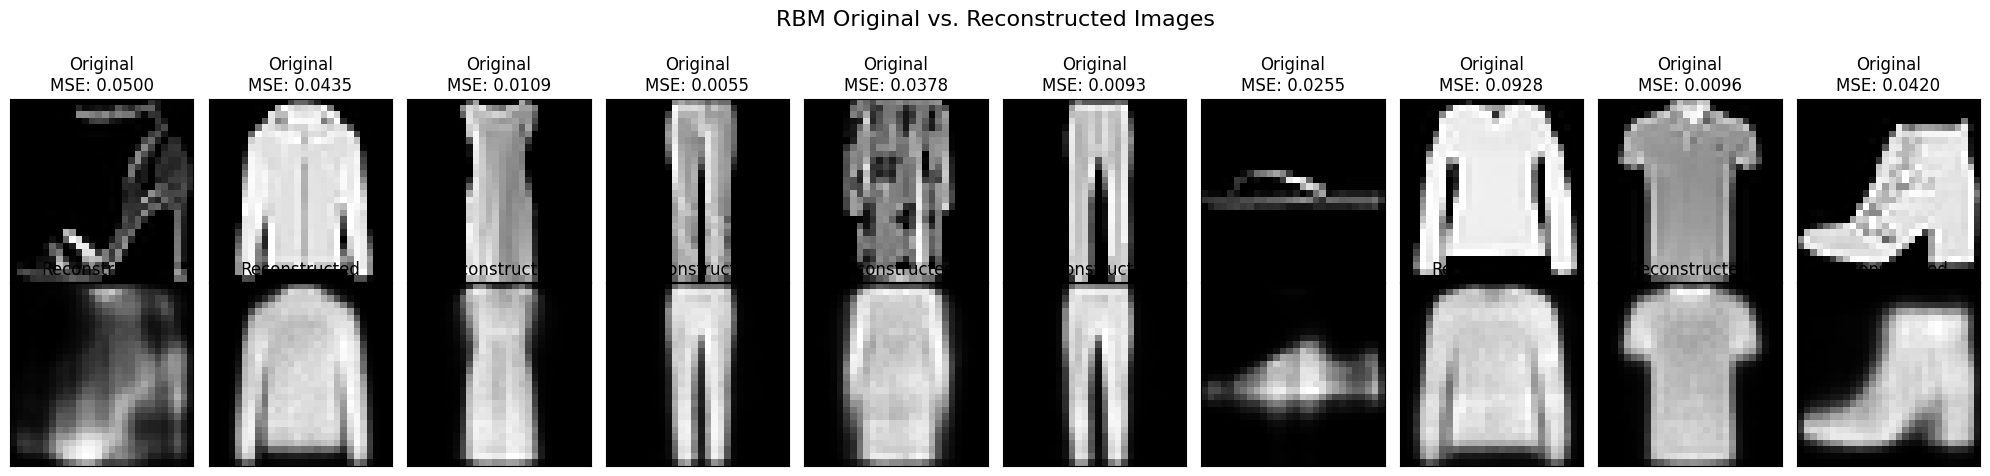

In [24]:
import matplotlib.pyplot as plt

# 1. Define a function to reconstruct visible units given an input
def reconstruct_rbm_visible(rbm_model, v):
    # First, sample hidden probabilities from the input visible units
    h_prob, _ = rbm_model.sample_hidden(v)
    # Then, get the reconstructed visible probabilities from the hidden probabilities
    v_recon_prob, _ = rbm_model.sample_visible(h_prob)
    return v_recon_prob

print("RBM reconstruction function defined.")

# 2. Select a small number of images from the validation set
num_images_to_show_rbm = 10
indices_rbm = np.random.choice(x_val.shape[0], num_images_to_show_rbm, replace=False)
sample_images_rbm = x_val[indices_rbm]

# 3. Pass these selected images through the RBM's reconstruction function
reconstructed_images_rbm = reconstruct_rbm_visible(rbm, sample_images_rbm)

# 4. Calculate the Mean Squared Error (MSE) between each original image and its reconstructed version
reconstruction_errors_rbm = np.array([mse_loss(sample_images_rbm[i].reshape(1, -1), reconstructed_images_rbm[i].reshape(1, -1)) for i in range(num_images_to_show_rbm)])

print("\nRBM Reconstruction Errors for selected images:")
for i, error in enumerate(reconstruction_errors_rbm):
    print(f"Image {i+1}: MSE = {error:.6f}")

# 5. Visualize the original and reconstructed images side-by-side
plt.figure(figsize=(20, 5))
for i in range(num_images_to_show_rbm):
    # Original Image
    ax = plt.subplot(2, num_images_to_show_rbm, i + 1)
    plt.imshow(sample_images_rbm[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Original\nMSE: {reconstruction_errors_rbm[i]:.4f}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Image
    ax = plt.subplot(2, num_images_to_show_rbm, i + 1 + num_images_to_show_rbm)
    plt.imshow(reconstructed_images_rbm[i].reshape(28, 28), cmap='gray')
    ax.set_title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle('RBM Original vs. Reconstructed Images', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()